In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

### Importation CSV et création du dataframe

In [3]:
df = pd.read_csv("data.csv")
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df

,State,BankState,Industry,Term,GrAppv,MIS_Status,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Real_estate
0,IN,OH,Retail trade,84,60000.0,0,4,1,0,0,1,0,0
1,IN,IN,Accommodation and food services,60,40000.0,0,2,1,0,0,1,0,0
2,IN,IN,Health care and social assistance,180,287000.0,0,7,0,0,0,1,0,0
3,OK,OK,Others,60,35000.0,0,2,0,0,0,1,0,0
4,FL,FL,Others,240,229000.0,0,14,0,7,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893285,OH,IL,Retail trade,60,70000.0,0,6,0,0,0,1,0,0
893286,OH,IL,Retail trade,60,85000.0,0,6,0,0,0,1,0,0
893287,CA,CA,Manufacturing,108,300000.0,0,26,0,0,0,1,0,0
893288,HI,HI,Others,60,75000.0,1,6,0,0,0,1,0,0


In [4]:
df.columns

Index(['State', 'BankState', 'Industry', 'Term', 'GrAppv', 'MIS_Status',
       'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode',
       'UrbanRural', 'Real_estate'],
      dtype='object')

In [5]:
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.FranchiseCode.value_counts()


1    841756
0     51534
Name: FranchiseCode, dtype: int64

### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [6]:
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8246873915525753

### Création d'un pipeline

In [7]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [53]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

0.5884543149681702

In [54]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [55]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__State_AK', 'onehotencoder__State_AL',
       'onehotencoder__State_AR', 'onehotencoder__State_AZ',
       'onehotencoder__State_CA', 'onehotencoder__State_CO',
       'onehotencoder__State_CT', 'onehotencoder__State_DC',
       'onehotencoder__State_DE', 'onehotencoder__State_FL',
       'onehotencoder__State_GA', 'onehotencoder__State_HI',
       'onehotencoder__State_IA', 'onehotencoder__State_ID',
       'onehotencoder__State_IL', 'onehotencoder__State_IN',
       'onehotencoder__State_KS', 'onehotencoder__State_KY',
       'onehotencoder__State_LA', 'onehotencoder__State_MA',
       'onehotencoder__State_MD', 'onehotencoder__State_ME',
       'onehotencoder__State_MI', 'onehotencoder__State_MN',
       'onehotencoder__State_MO', 'onehotencoder__State_MS',
       'onehotencoder__State_MT', 'onehotencoder__State_NC',
       'onehotencoder__State_ND', 'onehotencoder__State_NE',
       'onehotencoder__State_NH', 'onehotencoder__State_NJ',
       'onehotencoder__S

In [56]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
131,standardscaler__Term,0.356583
130,onehotencoder__Real_estate_1,0.128369
129,onehotencoder__Real_estate_0,0.098472
126,onehotencoder__UrbanRural_0,0.091182
135,standardscaler__RetainedJob,0.086116
127,onehotencoder__UrbanRural_1,0.05152
132,standardscaler__GrAppv,0.042971
115,onehotencoder__Industry_Others,0.032799
133,standardscaler__NoEmp,0.028626
96,onehotencoder__BankState_VA,0.010685


In [57]:
# plt.figure(figsize=[18,7])
# sns.barplot(data=df_coeff,x='features',y='coeff')
# plt.xticks(rotation=90)
# plt.title("Importance des variables explicatives")
# plt.show()

In [8]:
X = df[['UrbanRural','CreateJob','NoEmp','Real_estate','GrAppv','Industry','Term','State','BankState']]
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

In [59]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=10,
        n_estimators=100,
        min_samples_leaf=4000,
        min_samples_split=17000,
        class_weight='balanced',
        max_leaf_nodes=15
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a9b7d57e0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a9b7d7880>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=15,
                                        min_samples_leaf=4000,
                                        min_samples_split=17000))])

In [60]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

In [61]:
# train_sizes, train_scores, test_scores = learning_curve(estimator=forest, X=X_train, y=y_train,scoring='f1_macro' ,verbose=False)
# #
# # Calculate training and test mean and std
# #
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)
# #
# # Plot the learning curve
# #
# plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
# plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation F1')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
# plt.title('Learning Curve')
# plt.xlabel('Training Data Size')
# plt.ylabel('F1 score')
# plt.grid()
# plt.legend(loc='lower right')
# plt.show()

In [62]:
# y_pred=cross_val_predict(forest,X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86    590599
           1       0.44      0.82      0.57    125369

    accuracy                           0.79    715968
   macro avg       0.70      0.80      0.72    715968
weighted avg       0.86      0.79      0.81    715968



In [ ]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

0.7335996563881727

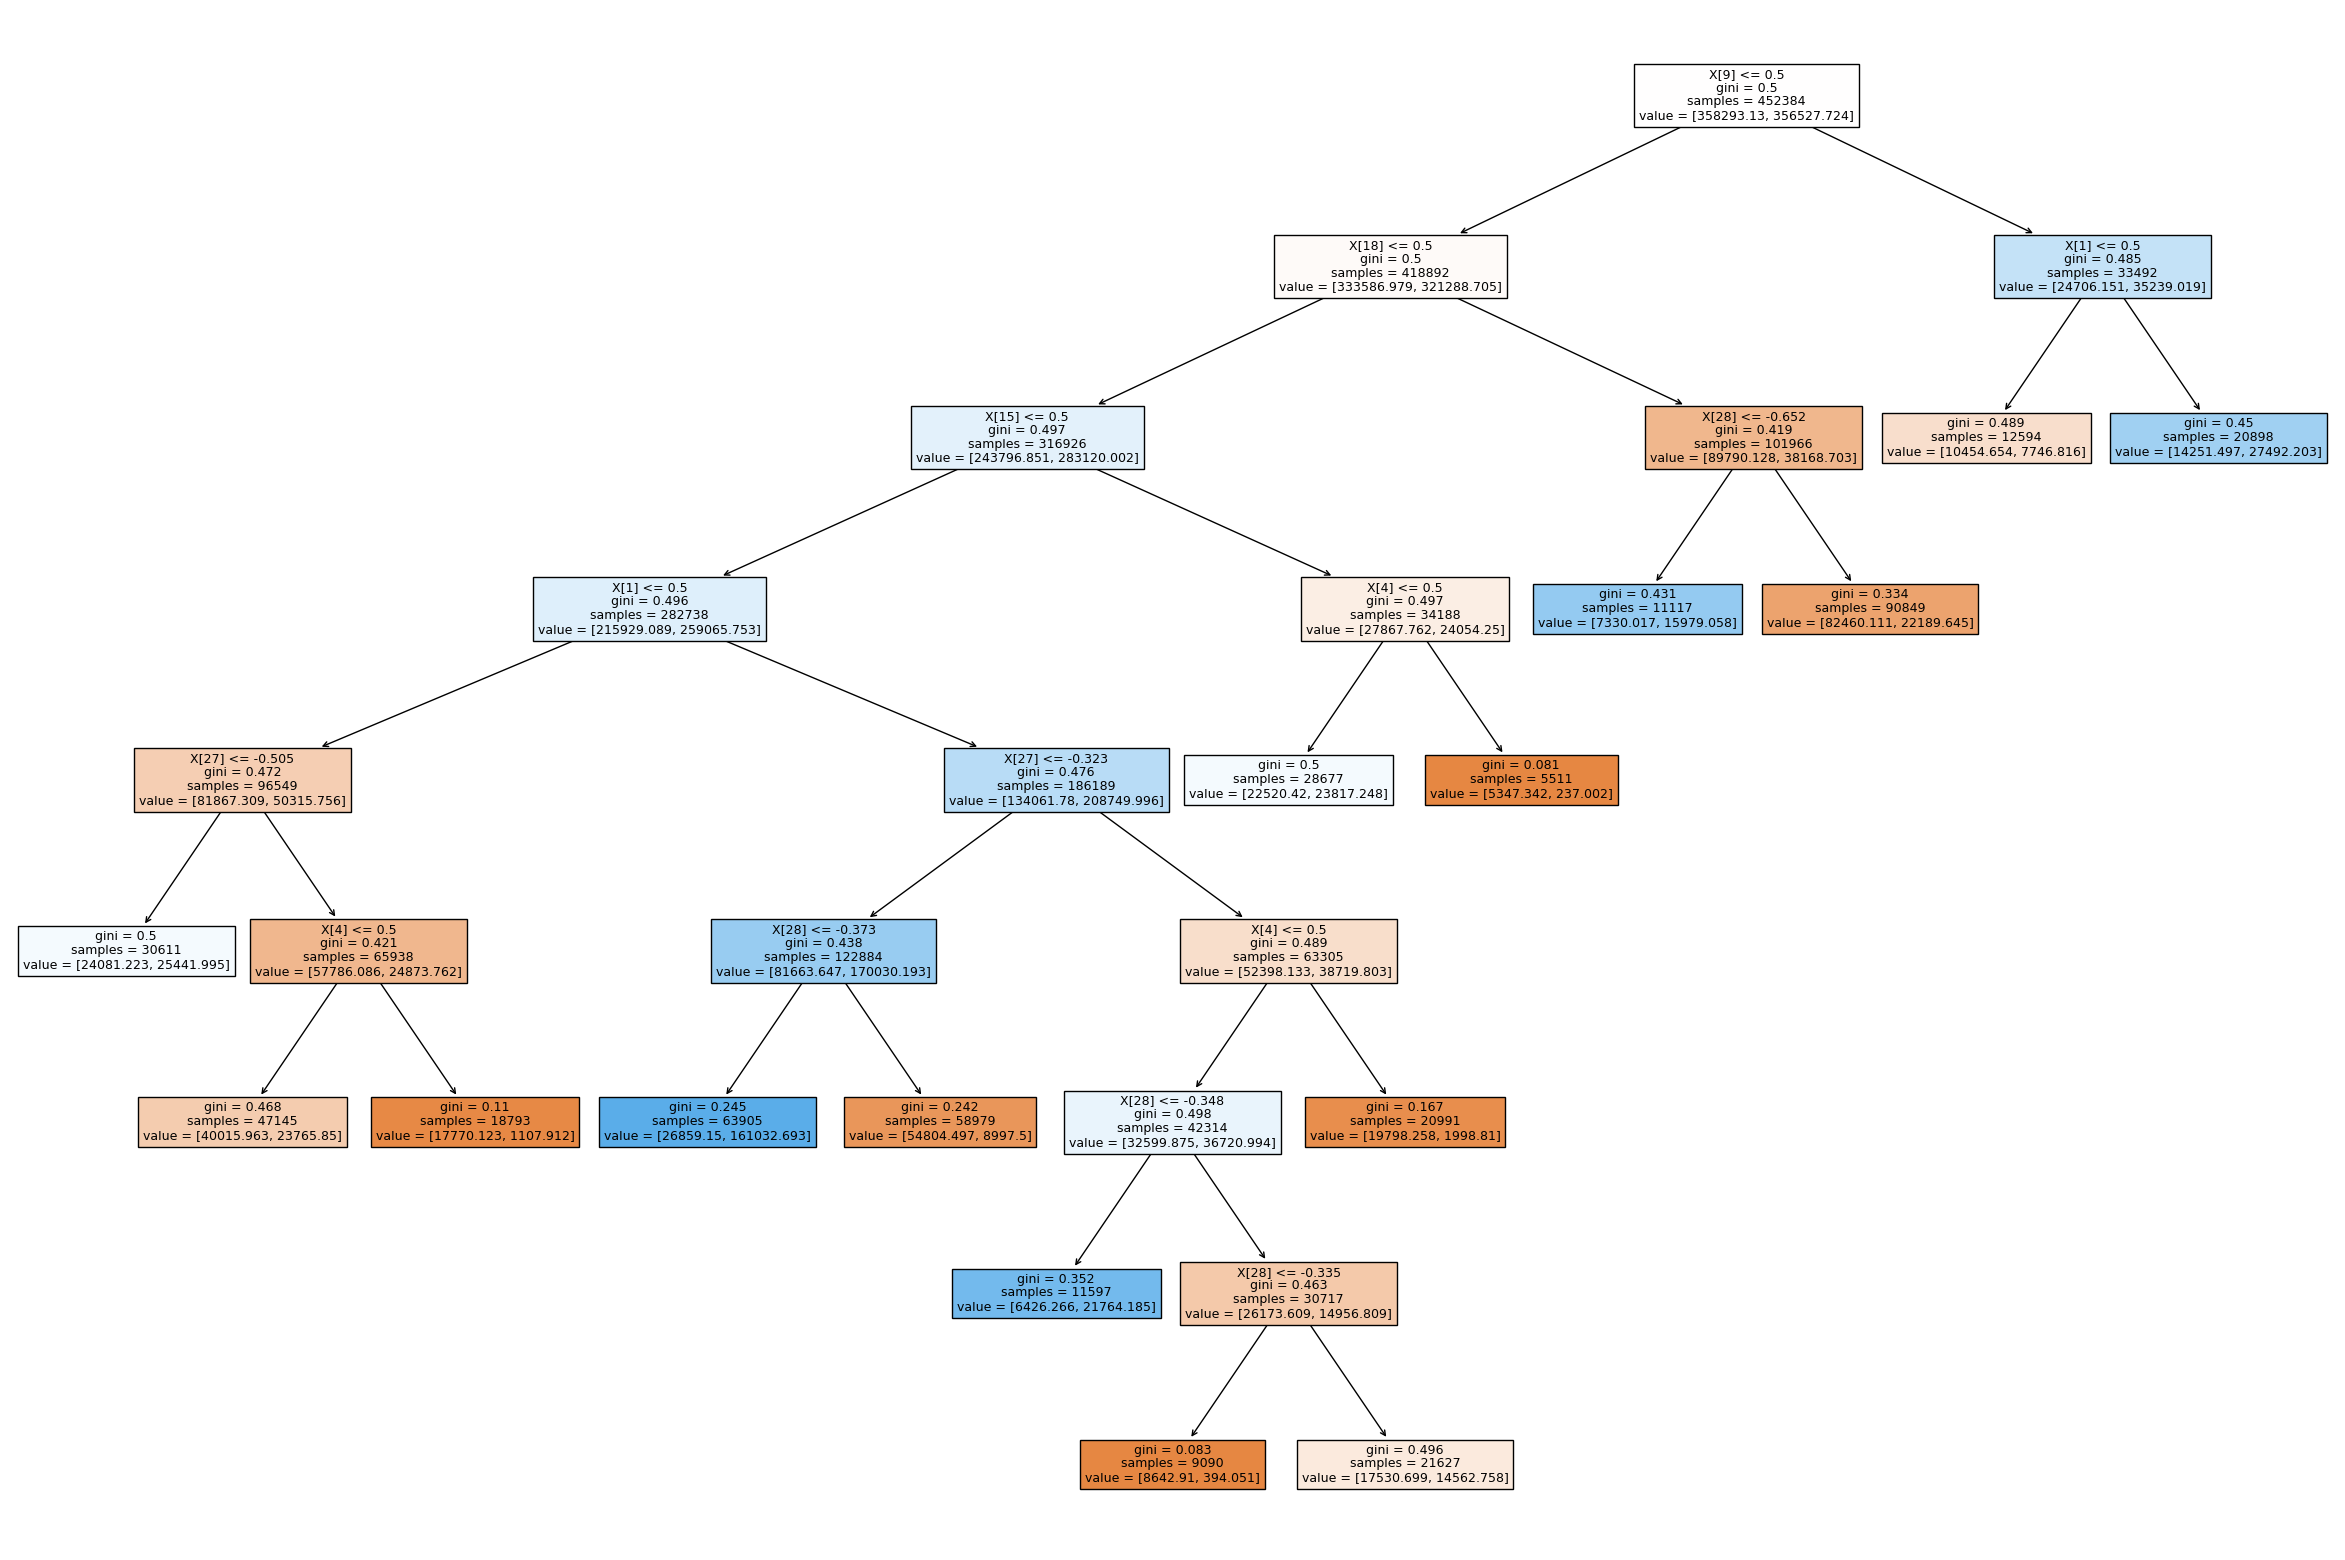

In [ ]:
# fig = plt.figure(figsize=(30,20))
# plot_tree(forest.named_steps['randomforestclassifier'].estimators_[0],filled=True)
# plt.show()

In [ ]:
# lo_reg = make_pipeline(
#     transformer,
#     LogisticRegression(
#         penalty='l2',
#         solver='saga',
#         class_weight='balanced',
#         multi_class='ovr'
#         )
#     )

# # Entrainement de notre modèle en utilisant les paramètres par défaut 
# lo_reg.fit(X_train,y_train)

# # Score de notre modèle après la cross_validation
# cross_val=cross_validate(lo_reg, X_train, y_train,scoring='f1',cv=5)
# cross_val['test_score'].mean()

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [ ]:
#Pour trouver le nom des paramètres590599
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfaf0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfc70>)])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', max_depth=5))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfaf0>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40ecfc70>)]),
 'randomforestclassifier': RandomForestClassi

In [ ]:
# param_rand = {'randomforestclassifier__min_samples_leaf':np.arange(1000,10000,100),
#               'randomforestclassifier__max_depth':np.arange(5,10,1),
#               'randomforestclassifier__min_samples_split':np.arange(1000,10000,100)
#                 }
                
# random_search = RandomizedSearchCV(forest, param_distributions=param_rand,scoring='f1', n_iter=1, cv=5, random_state=42)

# random_search.fit(X_train, y_train)
# print(random_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# random_search.best_estimator_
# random_search.best_score_

0.5789856443360211

### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [ ]:
# params = {'randomforestclassifier__min_samples_leaf':np.arange(2150,2300,1),
#           'randomforestclassifier__max_depth':[6]
#             }

# grid=GridSearchCV(forest, param_grid=params, scoring='f1', cv=5)
# grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# grid.best_score_

0.37606272607064106

# XGBOOST Classifier


In [9]:
from xgboost import plot_tree
from sklearn.metrics import f1_score,confusion_matrix
import seaborn as sns

In [10]:
XGB = make_pipeline(
    transformer,
    XGBClassifier(
        max_depth=10,
        learning_rate=0.1,
        n_estimators=100,
        gamma=50, 
        min_child_weight=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective='binary:logistic'
        )
    )

    

In [11]:

XGB.fit(X_train,y_train)

Xgb_score = cross_validate(XGB,X_train,y_train,cv=5,scoring='f1_macro')
Xgb_score['test_score'].mean()

0.8858176323124274

In [12]:
y_pred=cross_val_predict(XGB,X_train, y_train)
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96    589346
           1       0.85      0.78      0.81    125286

    accuracy                           0.94    714632
   macro avg       0.90      0.87      0.89    714632
weighted avg       0.93      0.94      0.94    714632



In [66]:
print(classification_report(y_test,XGB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95    147337
           1       0.79      0.68      0.73     31321

    accuracy                           0.91    178658
   macro avg       0.86      0.82      0.84    178658
weighted avg       0.91      0.91      0.91    178658



In [67]:
cm=confusion_matrix(y_train,y_pred)
cm
# df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJK"],
#                   columns = [i for i in "ABCDEFGHIJK"])
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

NameError: name 'confusion_matrix' is not defined